In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import box
from shapely.wkt import loads

2023-06-15 08:03:49.557356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 08:03:50.362447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 08:03:50.364692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 08:03:52.451493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Load the CSV data
data = pd.read_csv('final_data.csv')
# Preprocess the data
# Drop any unnecessary columns
data = data[['image_path', 'total_trip_count','geometry']]

# Filter out rows with missing image paths
data = data.dropna(subset=['image_path'])
print(data.shape)
# Create a bounding box
#nørreport box(12.563100, 55.682250,  12.573124, 55.685577) 
#hvidovre box(12.443359, 55.599086,  12.451035, 55.633655)
#dragør box(12.662613, 55.583994,  12.672050, 55.594517)
#55.755021, 12.530883

#55.740750, 12.559771




bbox = box(12.563100, 55.682984,  12.572124, 55.685577)  # Replace minx, miny, maxx, maxy with your actual coordinates


# Convert the geometry strings to Point objects
data['geometry'] = data['geometry'].apply(lambda x: loads(x))

# Convert the data to a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Filter out data outside the bounding box
data = gdf[gdf.geometry.within(bbox)]
print(data.shape)

(581102, 3)
(13823, 3)


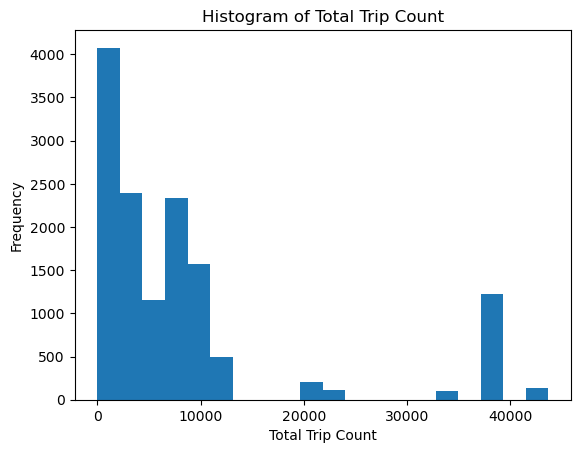

In [11]:
# Plot histogram
plt.hist(data['total_trip_count'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Total Trip Count')
plt.ylabel('Frequency')
plt.title('Histogram of Total Trip Count')
plt.show()

In [12]:
# Split the dataset into training and testing sets
X = data['image_path']
y = data['total_trip_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save y_train to a .npy file
np.save('y_train1.npy', y_train)

# Save y_test to a .npy file
np.save('y_test1.npy', y_test)

# Load pre-trained CNN (EfficientNetB0) without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from images using the pre-trained CNN
def extract_image_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    features = base_model.predict(img,verbose=0)
    return features.flatten()


# Define file paths for saving the features
train_features_file = 'train_features1.npy'
test_features_file = 'test_features1.npy'

# Create empty lists to store the features
train_image_features = []
test_image_features = []

# Extract image features
for image_path in tqdm(X_train):
    image_features = extract_image_features(image_path)
    if image_features is not None:
        train_image_features.append(image_features)
        
# Convert feature lists to numpy arrays
train_image_features = np.array(train_image_features)
# Save the features to files
np.save(train_features_file, train_image_features)

for image_path in tqdm(X_test):
    image_features = extract_image_features(image_path)
    if image_features is not None:
        test_image_features.append(image_features)
        
# Convert feature lists to numpy arrays
test_image_features = np.array(test_image_features)

# Save the features to files
np.save(test_features_file, test_image_features)


100%|███████████████████████████████████████████████████████████████████████████████| 2765/2765 [02:47<00:00, 16.54it/s]
